# Module: Paint

>  All the modules put together. The module takes galaxy catalog as input and outputs SED along with photometry 

In [ ]:
#| default_exp paint

In [ ]:
#| hide

import matplotlib.pylab as plt
import matplotlib as mpl

#### 1. First we import the following modules of hydro_colors 

In [ ]:
#| export

import watercolor
from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data, GALS_FILE
from watercolor.calculate_csp import calc_fluxes_for_galaxy
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE
from watercolor.dust_attenuation import spectrum_dusted, log_total_stellar_metal, log_total_stellar_mass
from watercolor.cosmic_distance_effects import combine_redshift_and_dimming_effect
from watercolor.filter_convolution import load_survey_pickle, photometry_from_spectra

In [ ]:
#| export 

import numpy as np

In [ ]:
#| export

def photometry_from_catalog(galaxy_star_catalog_file:str=GALS_FILE, # Input galaxy catalog
                            galaxy_redshift:np.float32=0.001, # Galaxy redshift
                           )->tuple:# [SED, wavelengths, broadband magnitudes from lsst, cosmos, spherex]
    
    # load catalog from HACC
    fof_halo_tag, if_satellite, galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, x, y, z , vx, vy, vz = load_hacc_galaxy_data(galaxy_star_catalog_file)
    num_galaxies_in_catalog = np.unique(galaxy_tags).shape[0]
    print('Number of galaxies: %d'%num_galaxies_in_catalog)

    
    final_sed_mJy = np.zeros(shape=(num_galaxies_in_catalog, 1963)) ## SED resolution is 1963
    final_wave_um = np.zeros(shape=(num_galaxies_in_catalog, 1963)) ## SED resolution is 1963
    lsst_mags = np.zeros(shape=(num_galaxies_in_catalog, 6)) ## 6 LSST bands
    spherex_mags = np.zeros(shape=(num_galaxies_in_catalog, 197)) ## 197 SPHEREx channels
    cosmos_mags = np.zeros(shape=(num_galaxies_in_catalog, 31)) ## 31 COSMOS bands
    
    for galaxy_number in range(np.unique(galaxy_tags).shape[0]):
        # Go through all the galaxies in the catalog (the unique galaxy tags)
    
        unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]

        mstar_i = mass[galaxy_tags == unique_galaxy_tag]
        metal_i = metal_hydro[galaxy_tags == unique_galaxy_tag]

        logZ = log_total_stellar_metal(metal_i, mstar_i)
        logmstar = log_total_stellar_mass(mstar_i)
        
        # We now calculate the SED. This is the rest-frame SED is due to spectral emission alone, and without dust attenuation.
        spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(galaxy_star_catalog_file,
                                                                                                                               unique_galaxy_tag,
                                                                                                                               LIBRARY_FLUX_FILE,
                                                                                                                               LIBRARY_WAVE_FILE,
                                                                                                                               LIBRARY_AGE_FILE,
                                                                                                                               LIBRARY_METAL_FILE)
        # Dust attenuation
        spec_wave_csp_dusted = spectrum_dusted(spec_csp, spec_wave_ssp, logmstar, logZ, galaxy_redshift) # (spec_csp in L_bolometric A^-1)
        
        # Cosmic redshifting and dimming
        redsh_wave, redsh_spec = combine_redshift_and_dimming_effect(wave=spec_wave_ssp, 
                                                             spec=spec_wave_csp_dusted, 
                                                             galaxy_redshift=galaxy_redshift) # redsh_wave in [A], redsh_spec in [mJy]
        
        
        sed_um_wave = redsh_wave/1e4 # in um
        sed_mJy_flux = redsh_spec/1e3  ## in mJy
        
        
        # Filter convolution - LSST
        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names_lsst = load_survey_pickle('LSST')
        
        _, appmag_ext_lsst, _ = photometry_from_spectra(central_wavelengths, 
                                                        sed_um_wave, 
                                                        sed_mJy_flux, 
                                                        bandpass_wavs, 
                                                        bandpass_vals, 
                                                        bandpass_names,
                                                        interp_kind='linear',
                                                        plot=False,
                                                        clip_bandpass=True)
        
        # Filter convolution - SPHEREx
        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names_spherex = load_survey_pickle('SPHEREx')
        
        _, appmag_ext_spherex, _ = photometry_from_spectra(central_wavelengths, 
                                                           sed_um_wave, 
                                                           sed_mJy_flux, 
                                                           bandpass_wavs, 
                                                           bandpass_vals, 
                                                           bandpass_names,
                                                           interp_kind='linear',
                                                           plot=False,
                                                           clip_bandpass=True)
        
        # Filter convolution - COSMOS
        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names_cosmos = load_survey_pickle('COSMOS')
        
        _, appmag_ext_cosmos, _ = photometry_from_spectra(central_wavelengths, 
                                                          sed_um_wave, 
                                                          sed_mJy_flux, 
                                                          bandpass_wavs, 
                                                          bandpass_vals, 
                                                          bandpass_names,
                                                          interp_kind='linear',
                                                          plot=False,
                                                          clip_bandpass=True)


        # Appending the relevant quantities
        final_sed_mJy[galaxy_number] = sed_mJy_flux
        final_wave_um[galaxy_number] = sed_um_wave
        lsst_mags[galaxy_number] = appmag_ext_lsst
        spherex_mags[galaxy_number] = appmag_ext_spherex
        cosmos_mags[galaxy_number] = appmag_ext_cosmos
    
    return final_sed_mJy, final_wave_um, lsst_mags, spherex_mags, cosmos_mags

In [ ]:
#| hide

final_sed_mJy, final_wave_um, lsst_mags, spherex_mags, cosmos_mags = photometry_from_catalog(GALS_FILE)

Number of galaxies: 200


(0.01, 2.2)

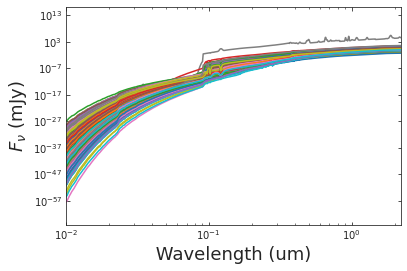

In [ ]:
#| hide

plt.figure()

for gal_id in range(final_wave_um.shape[0]):
# for gal_id in range(1,2):
    # print(gal_id)
    plt.plot(final_wave_um[gal_id], final_sed_mJy[gal_id])
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$F_\nu$ (mJy)', fontsize=18)
plt.xlabel(' Wavelength (um) ', fontsize=18)
# plt.xlim(3e3, 1e4)
plt.xlim(0.01, 2.2)

In [ ]:
# #| hide 

# # u-g, g-r, i-z

# plt.scatter(u-g, g-r)


# # red # g-r > 1.3
# # blue # g-r < 0.1

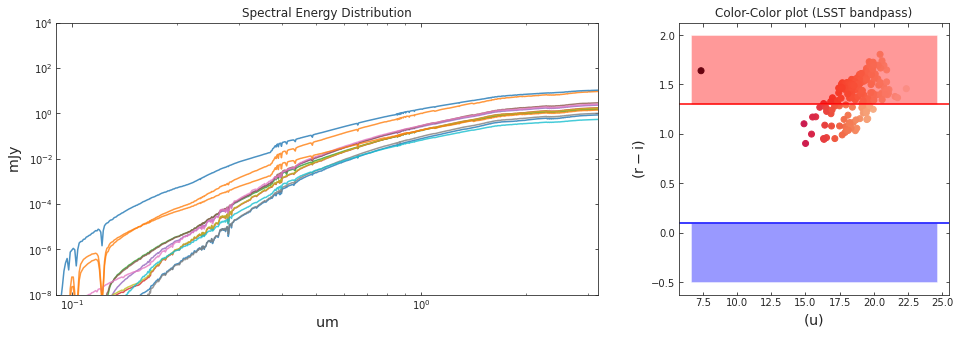

In [ ]:
#| hide

# Plotting SEDs and LSST colors
f, ax = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1]})

ax[0].set_title('Spectral Energy Distribution')
ax[1].set_title('Color-Color plot (LSST bandpass)')


for gal_id in np.random.randint(0, final_sed_mJy.shape[0], 12):
    ax[0].plot(final_wave_um[gal_id], final_sed_mJy[gal_id], label=str(gal_id), alpha=0.8)

ax[0].set_xlim(0.09, 3.2)
ax[0].set_ylim(1e-8, 1e4)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel(r'${\rm um}$', fontsize = 'x-large')
ax[0].set_ylabel(r'${\rm mJy}}$', fontsize = 'x-large')
# ax[0].legend(fontsize='x-large', ncol=3, title='Galaxy number')

u, g, r, i, z, Y = lsst_mags.T

# ax[1].scatter(u, g-r, c=range(final_sed_mJy.shape[0]))
ax[1].scatter(u, g-r, c=u)

ax[1].set_xlabel(r'${\rm (u)}$', fontsize = 'x-large')
ax[1].set_ylabel(r'${\rm (r-i)}$', fontsize = 'x-large')

ax[1].axhline(y=1.3, color='red')
ax[1].axhline(y=0.1, color='blue')

ax[1].fill_between( np.linspace(0.9*u.min(), 1.1*u.max(), 100), 1.3, 2.0,  facecolor='red', alpha=0.4, interpolate=True)
ax[1].fill_between( np.linspace(0.9*u.min(), 1.1*u.max(), 100), -0.5, 0.1,  facecolor='blue', alpha=0.4, interpolate=True)

plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

<!-- ### One can also find luminosity profiles for the simulated galaxies -->